# Model HI Global Profiles

Idea is to 
1. Input: 
* HI global profile
* MaNGA velocity field (from Halpha)
* Estimated inclination
* Measurement of HI vel at estimated $R_{HI}$ 
2. Get out a HI radial profile (HI surface mass density as a function of radius of the disk). This profile shoudl:
  * Integrate (sum up) to the total HI mass under the HI global profile
  * Recreate the HI global profile when combined with the rotation curve/velocity field of the galaxy

Let's see what we can do! 

## Definitions you need to understand

* HI global profile
* HI radial profile
* HI mass
* HI surface mass density
* Inclination

## Toy Model

Let's make a really simple model first that you can play with to see what happens. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Initial assumption of value of log MHI/Msun
mHI = 10 #Change to see impact
print('log (HI mass/Msun) = ', mHI)

log (HI mass/Msun) =  10


In [3]:
# Estimate of HI radius (Equation 6 Stevens et al. 2019)
logDHI = 0.5*mHI - 3.236 #log(DHI/1kpc)
rHI = (10**logDHI)/2 #HI radius in kpc
print('HI radius (in kpc): ', rHI)
r = np.arange(0, 2, 0.02) #Setting up an array of radii in units of r/rHI

HI radius (in kpc):  29.03822087606559


# Toy model rotation curve

Rotation Curve model function is a combination of hyperbolic tangent function and a linear term.
            $V (r) = V_c \tanh(r/Rt) + (s_{out})r$
        
* $Vc = mHi+Mstar$ (called the Baryonic Tully-Fisher Relation), and Vc is maximum V(r) for a flat rotation curve when $s_{out}=0$
* $s_{out} = 0$, and $s_{out}$ is the slope of Rotation Curve (RC) at a large radii r>>Rt
* $R_t$ is the turnover radius, from Yoon et al. 2021 Fig.3

Rotation curve parameters, Vc; Rt and sout 250 2 0
Inclination 80.0


Text(0, 0.5, 'Circular velocity')

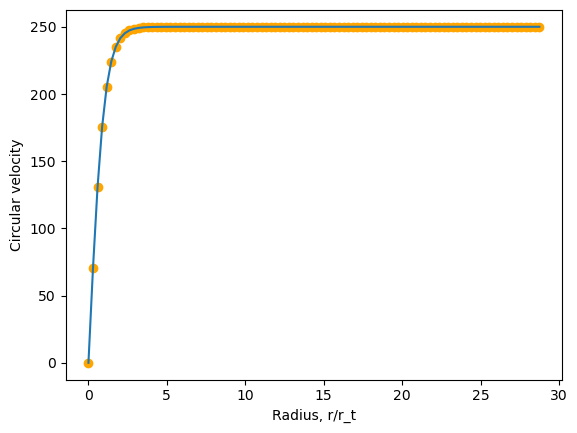

In [11]:
#Rotation curve model Vr = Vc * np.tanh(r_Rt) + sout*r (function used in Yoon et al. 2021: https://ui.adsabs.harvard.edu/abs/2021ApJ...922..249Y/abstract) 
Vc = 250 # circular velocity (in km/s)
# Would be better model if Vc came from MHI+Mstar (called the Baryonic Tully-Fisher Relation). 
Rt = 2 # in kpc
inc=80.0 #Inclination in degrees
sout = 0
print('Rotation curve parameters, Vc; Rt and sout', Vc, Rt, sout)
print('Inclination',inc)

r_Rt = (rHI*r)/Rt #Makes an array of radius in units of Rt from our array in units of rHI
Vr = Vc * np.tanh(r_Rt) + sout*r

plt.plot(r_Rt,Vr)
plt.scatter(r_Rt,Vr,c='orange')
plt.xlabel('Radius, r/r_t')
plt.ylabel('Circular velocity')

# HI Radial Profile

In the Stevens et al., some models for going about this were given.
    
    Model 0: pure exponential
        Size mass relation, equations #4 and #6
    
    Equation #6, 
        log(DHi/kpc) = 0.5 * log(mHi/Msun) - 3.236
    Equation #4, 
        rHi = ln(E0/Ec) * rs

Text(0, 0.5, '$\\log \\Sigma_{HI}$')

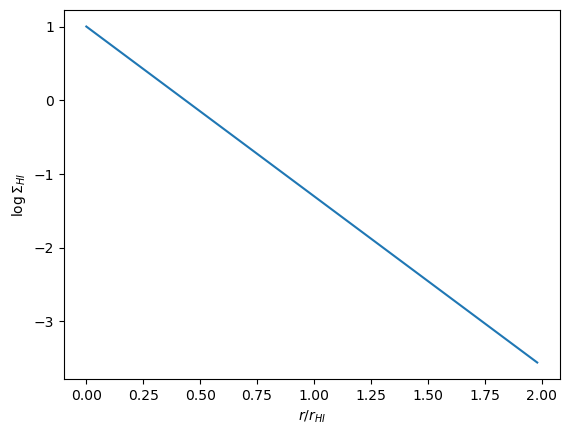

In [16]:
#Model for HI profile (exponential thin disc with scale radius equal to RHI)
E0 = 10.0 # units M_sun*pc^(-2), central Hi surface density
Ec = 1.0 # units M_sun*pc^(-2)
logEHI = np.log10(E0) - np.log(E0/Ec)*r #units M_sun*pc^(-2) - HI surface density at a given radius.  

plt.plot(r,logEHI)
plt.xlabel(r'$r/r_{HI}$')
plt.ylabel(r'$\log \Sigma_{HI}$')


/var/folders/v0/6ck1sx_n1cj3xv334vm2x_mw0000gq/T/ipykernel_58557/2125625607.py:40: RuntimeWarning: divide by zero encountered in log
  plt.scatter(LOSvel, np.log(HImass),marker='.',s=0.01)


Text(0, 0.5, 'HI mass of little chunk of galaxy ($\\log M_{HI}/M_{\\odot}$)')

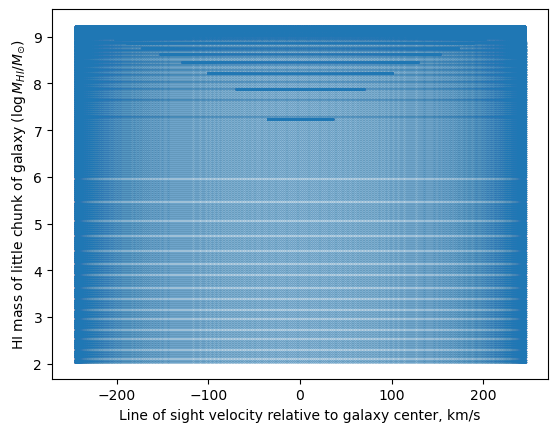

In [30]:
#Now put this all together. First set up arrays of radius and aximuthal angle (phi)

dr = 0.01
drpc = dr*rHI*1000
radius = np.arange(0, 2, dr) #r/rHI

dphi = 0.1
phideg= np.arange(0,360,dphi) #aximuth angle in degrees

#Arrays for the HI surface mass and line of sight velocity (the thing which sets up the frequency of the HI)
HImass = []
LOSvel = []

#Loop over radial rings at all aximuth (assumes circularly symmetric)
#This migth not be the best grid, but it's easy! 
for r in radius: 
    for phi in phideg: 
        rpc = r*rHI*1000
        Area = rpc*drpc*dphi*np.pi/180.0 #Area in pc^2
            
        #Surface density of HI units M_sun*pc^(-2) - HI surface density at a given radius.  
        logEHI = np.log10(E0) - np.log(E0/Ec)*r
        
        #Mass HI in area segment
        MassHI = Area*(10**logEHI)

        # Circular velocity
        r_Rt = (rHI*r)/Rt
        Vr = Vc * np.tanh(r_Rt) + sout*r
        
        #LOS velocity
        vlos = Vr*np.sin(inc*np.pi/180.0)*np.cos(phi*np.pi/180.0)

        HImass.append(MassHI)
        LOSvel.append(vlos)
        
HImass=np.array(HImass)
LOSvel=np.array(LOSvel)

#This plot makes no sense, but just showing you so many points (for most choices of dr, dphi)
plt.scatter(LOSvel, np.log(HImass),marker='.',s=0.01)
plt.xlabel('Line of sight velocity relative to galaxy center, km/s')
plt.ylabel(r'HI mass of little chunk of galaxy ($\log M_{HI}/M_{\odot}$)')


Text(0, 0.5, 'HI luminosity in units of HI mass')

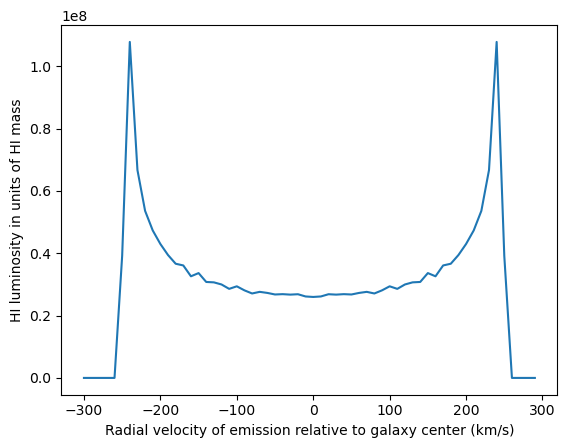

In [31]:
# Now sum this up into a HI global profile, which means sum in ranges of dv
# Probably a cleverer way to do this with the histogram function in numpy

dv=5
minvel=-Vc-50.0
maxvel=Vc+50.0
channels = np.arange(minvel,maxvel,2*dv)

Flux=[]

for vel in channels:
        minv=vel-dv
        maxv=vel+dv
        totalmass=sum(HImass[(LOSvel>minv)&(LOSvel<maxv)])

        Flux.append(totalmass)
        
plt.plot(channels,Flux)
plt.xlabel('Radial velocity of emission relative to galaxy center (km/s)')
plt.ylabel('HI luminosity in units of HI mass')

